# From Data to Intelligence — Workshop Notebook (Post-run)
**Theme:** Predicting Your Launchpad (Career Trajectories)  
**Flow:** Classical ML (multiclass classification) → GenAI (explain + uplift plan)  
**Offline-safe:** This notebook is **pre-run** with outputs so the workshop never depends on internet speed or installs.

> Important workshop note:
>  
> This dataset is **synthetic and mostly linear by design**, created to clearly demonstrate how classical machine learning works.
> Because of this, **simpler models like Logistic Regression may perform as well as or better than more complex models like Random Forest**.
>  
> This is intentional and reflects a real industry lesson:
> **the best model is the one that fits the data — not the most complex one.**


## 0) Setup: 3 career trajectory tiers (multiclass)
We will predict a student's **career trajectory** as one of three tiers:

- **Tier 1 — Product / Core:** product teams, R&D, deep-tech startups  
- **Tier 2 — Specialized / Niche:** niche roles, strong engineering depth, fast-growing teams  
- **Tier 3 — Core Foundations:** large-scale hiring, foundational engineering teams  

This is a **multiclass classification** problem (3 classes).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


## 1) Create a student dataset (toy, but relatable)
Inputs (features):
- **attendance_%**: consistency
- **academic_score**: marks / fundamentals
- **project_strength**: projects (differentiator)

Target (label):
- **trajectory_tier** ∈ {Tier 1, Tier 2, Tier 3}

We keep this dataset **mostly linear** so learning is clear and interpretable.


In [2]:
rng = np.random.default_rng(42)
n = 1500

attendance = rng.normal(78, 10, n).clip(40, 100)   # %
academic   = rng.normal(70, 12, n).clip(20, 100)   # /100

# Projects strongly informative + mildly tied to academics (realistic-ish)
project = (0.55*academic + rng.normal(0, 10, n)).clip(0, 100)

# Main "launchpad score" (mostly linear) + small noise
noise = rng.normal(0, 0.55, n)

launchpad_score = (
    0.03*(attendance - 70) +
    0.06*(academic - 60) +
    0.10*(project - 50) +
    noise
)

# Convert into 3 tiers using thresholds (ordered, but treated as classes)
tier = np.where(launchpad_score > 2.0, "Tier 1",
        np.where(launchpad_score > 0.8, "Tier 2", "Tier 3"))

df = pd.DataFrame({
    "attendance_%": attendance.round(1),
    "academic_score": academic.round(1),
    "project_strength": project.round(1),
    "trajectory_tier": tier
})

df.head()


,attendance_%,academic_score,project_strength,trajectory_tier
0,81.0,63.2,47.3,Tier 3
1,67.6,62.5,41.3,Tier 3
2,85.5,85.9,66.9,Tier 1
3,87.4,74.0,25.2,Tier 3
4,58.5,67.5,34.4,Tier 3


In [3]:
df["trajectory_tier"].value_counts()


,count
trajectory_tier,
Tier 3,1099
Tier 2,251
Tier 1,150


### Quick visual intuition


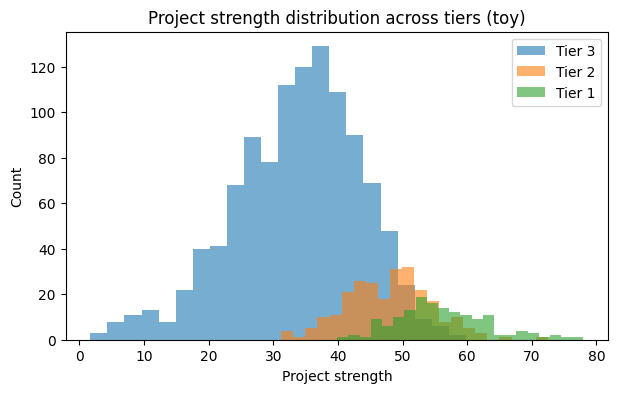

In [4]:
fig = plt.figure(figsize=(7,4))
for t in ["Tier 3","Tier 2","Tier 1"]:
    plt.hist(df.loc[df.trajectory_tier==t, "project_strength"], bins=22, alpha=0.6, label=t)
plt.title("Project strength distribution across tiers (toy)")
plt.xlabel("Project strength")
plt.ylabel("Count")
plt.legend()
plt.show()


## 2) Train / test split (honest evaluation)
We keep evaluation honest with a held-out test set (unseen students).


In [5]:
X = df[["attendance_%","academic_score","project_strength"]]
y = df["trajectory_tier"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))


Train size: 1125 Test size: 375


## 3) Model A — Logistic Regression (Strong Baseline)
Logistic Regression is a **linear model** that works extremely well when:
- relationships between features and outcome are mostly linear
- data is clean and low-noise
- interpretability and simplicity matter


In [6]:
# Logistic Regression is well-matched to mostly linear decision boundaries.
# On clean, structured data like this, it can perform extremely well.
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=700, multi_class="multinomial"))
])

logreg.fit(X_train, y_train)
pred_lr = logreg.predict(X_test)

acc_lr = accuracy_score(y_test, pred_lr)
print("LogReg accuracy:", round(acc_lr, 4))


LogReg accuracy: 0.9093


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## 4) Model B — Random Forest (More Flexible, More Complex)
Random Forest is a non-linear model that can capture interactions.
But higher complexity does not guarantee better performance.


In [7]:
# Random Forest can model non-linear interactions,
# but may not outperform simpler models if the underlying pattern is mostly linear.
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, pred_rf)
print("Random Forest accuracy:", round(acc_rf, 4))

# Accuracy should always be interpreted in the context of data structure and problem goals.


Random Forest accuracy: 0.8747


### Key Learning: Model Choice Depends on Data
You may observe that **Logistic Regression performs as well as or better than Random Forest** on this dataset.

This is not a mistake.

> **More complex models are not always better.**


## 5) Confusion matrix (use the better-performing model)
We will pick the model with higher test accuracy for the rest of the demo.


In [8]:
best_model = logreg if acc_lr >= acc_rf else rf
best_name = "Logistic Regression" if best_model is logreg else "Random Forest"

print("Using model for demo:", best_name)

best_pred = pred_lr if best_model is logreg else pred_rf
labels = ["Tier 1","Tier 2","Tier 3"]
cm = confusion_matrix(y_test, best_pred, labels=labels)

print(pd.DataFrame(cm, index=labels, columns=labels))


Using model for demo: Logistic Regression
        Tier 1  Tier 2  Tier 3
Tier 1      29       8       0
Tier 2       7      42      14
Tier 3       0       5     270


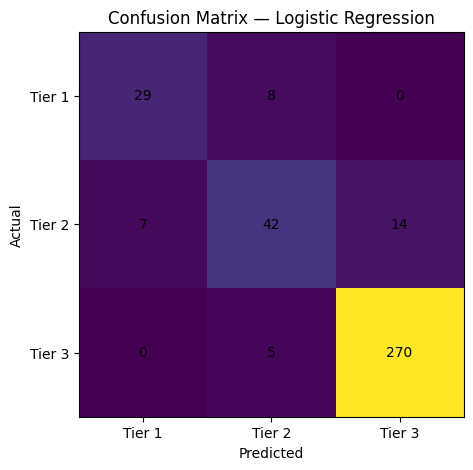

In [9]:
fig = plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title(f"Confusion Matrix — {best_name}")
plt.xticks([0,1,2], labels)
plt.yticks([0,1,2], labels)
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 6) “What-if” demo: see probabilities shift


In [10]:
def predict_with_probs(model, attendance_pct, academic_score, project_strength):
    row = pd.DataFrame([{
        "attendance_%": attendance_pct,
        "academic_score": academic_score,
        "project_strength": project_strength
    }])
    probs = model.predict_proba(row)[0]
    tiers = model.named_steps["clf"].classes_ if hasattr(model, "named_steps") else model.classes_
    out = pd.DataFrame({"tier": tiers, "prob": probs}).sort_values("prob", ascending=False)
    return out, row

profiles = [
    ("Profile A (strong projects)", 82, 72, 88),
    ("Profile B (average)",        75, 66, 55),
    ("Profile C (low projects)",   80, 70, 30),
]

for name, a, ac, p in profiles:
    out, _ = predict_with_probs(best_model, a, ac, p)
    print("\n" + name)
    print(out.to_string(index=False))



Profile A (strong projects)
  tier         prob
Tier 1 9.993963e-01
Tier 2 6.036653e-04
Tier 3 2.286045e-08

Profile B (average)
  tier     prob
Tier 2 0.486365
Tier 3 0.476216
Tier 1 0.037419

Profile C (low projects)
  tier     prob
Tier 3 0.994658
Tier 2 0.005340
Tier 1 0.000002


## 7) GenAI extension (offline-safe + optional Groq)
ML gives probabilities and a predicted tier. GenAI converts that into:
- a simple explanation
- a 7-day uplift plan
- suggested project direction


### 7.1 Build a prompt (what we'd send to GenAI)


In [11]:
def build_genai_prompt(student_row: pd.DataFrame, prob_table: pd.DataFrame, model_name: str) -> str:
    s = student_row.iloc[0].to_dict()
    top_tier = prob_table.iloc[0]["tier"]
    return f"""You are an AI mentor for engineering students (India context).
We are discussing career trajectory tiers (Tier 1/2/3). Be supportive and practical.

Student signals:
- Attendance (%): {s['attendance_%']}
- Academic score (/100): {s['academic_score']}
- Project strength (/100): {s['project_strength']}

ML model used: {model_name}
Prediction (multiclass):
- Predicted trajectory: {top_tier}
- Probabilities:
{prob_table.to_string(index=False)}

Task:
1) Explain the result in simple terms (max 5 bullets)
2) Give a 7-day uplift plan (max 6 bullets)
3) Suggest 2 realistic technical projects to increase 'project_strength'
Return clean bullets only."""


### 7.2 Offline-safe GenAI response (template-based)
This simulates what an LLM could generate so the notebook works without internet.


In [12]:
def simulated_genai_response(predicted_tier: str, prob_table: pd.DataFrame) -> str:
    p_map = {r["tier"]: float(r["prob"]) for _, r in prob_table.iterrows()}
    return (
        "Explanation (simple):\n"
        f"- Your current best-aligned trajectory is **{predicted_tier}** based on patterns in consistency, academics, and projects.\n"
        f"- Probabilities: Tier 1={p_map.get('Tier 1',0):.2f}, Tier 2={p_map.get('Tier 2',0):.2f}, Tier 3={p_map.get('Tier 3',0):.2f}.\n"
        "- Biggest lever to move upward is usually stronger projects + consistent effort.\n"
        "- Treat this as a snapshot today, not a permanent label.\n"
        "\n"
        "7-day uplift plan:\n"
        "- Day 1: Pick one project theme + set a 60–90 min daily slot.\n"
        "- Day 2–3: Build a mini-project with README + demo output.\n"
        "- Day 4: Add one measurable improvement (metric/plot).\n"
        "- Day 5: Practice a 2-minute explanation of your project and learnings.\n"
        "- Day 6: Strengthen fundamentals with focused practice.\n"
        "- Day 7: Update GitHub + resume with proof (plots/metrics/demo).\n"
        "\n"
        "Two realistic project ideas:\n"
        "- Signal classification: FFT features -> multiclass model -> confusion matrix.\n"
        "- Sensor anomaly detection: features -> classifier -> plots.\n"
    )


### 7.3 Optional: Real GenAI using Groq (Colab Secrets)
If you have a Groq API key:
- In Colab: open the Secrets panel and add `GROQ_API_KEY`

Then this notebook will call Groq for a real GenAI answer and save outputs to a JSON file.
If no key is available, it will fall back to the simulated response.


In [14]:
import os, json
from datetime import datetime
from google.colab import userdata

GROQ_API_KEY = userdata.get("GROQ_API_KEY")

# Choose one profile to demo GenAI
prob_table, student_row = predict_with_probs(best_model, 82, 72, 88)
predicted = prob_table.iloc[0]["tier"]
model_name_for_prompt = best_name

prompt = build_genai_prompt(student_row, prob_table, model_name_for_prompt)

def call_groq_llm(prompt: str) -> str:
    from groq import Groq
    client = Groq(api_key=GROQ_API_KEY)
    resp = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[
            {"role":"system","content":"You are a practical AI mentor for engineering students."},
            {"role":"user","content":prompt}
        ],
        temperature=0.4,
    )
    return resp.choices[0].message.content

source = "offline_simulation"
genai_output = simulated_genai_response(predicted, prob_table)

if GROQ_API_KEY:
    try:
        # Optional: install groq if missing (requires internet)
        try:
            import groq  # noqa: F401
        except Exception:
            import subprocess, sys
            subprocess.run([sys.executable, "-m", "pip", "-q", "install", "groq"], check=True)
        genai_output = call_groq_llm(prompt)
        source = "groq_api"
    except Exception as e:
        source = f"offline_simulation (groq failed: {type(e).__name__})"
        genai_output = simulated_genai_response(predicted, prob_table)

print(f"GenAI output source: {source}\n")
print(genai_output[:1500] + ("..." if len(genai_output) > 1500 else ""))


GenAI output source: offline_simulation (groq failed: BadRequestError)

Explanation (simple):
- Your current best-aligned trajectory is **Tier 1** based on patterns in consistency, academics, and projects.
- Probabilities: Tier 1=1.00, Tier 2=0.00, Tier 3=0.00.
- Biggest lever to move upward is usually stronger projects + consistent effort.
- Treat this as a snapshot today, not a permanent label.

7-day uplift plan:
- Day 1: Pick one project theme + set a 60–90 min daily slot.
- Day 2–3: Build a mini-project with README + demo output.
- Day 4: Add one measurable improvement (metric/plot).
- Day 5: Practice a 2-minute explanation of your project and learnings.
- Day 6: Strengthen fundamentals with focused practice.
- Day 7: Update GitHub + resume with proof (plots/metrics/demo).

Two realistic project ideas:
- Signal classification: FFT features -> multiclass model -> confusion matrix.
- Sensor anomaly detection: features -> classifier -> plots.



### 7.4 Save GenAI output (useful for later testing)


In [15]:
output_record = {
    "timestamp_utc": datetime.utcnow().isoformat(),
    "genai_source": source,
    "ml_model_used": model_name_for_prompt,
    "input_signals": student_row.iloc[0].to_dict(),
    "prediction_probs": prob_table.to_dict(orient="records"),
    "prompt": prompt,
    "genai_output": genai_output
}

out_path = "genai_launchpad_output.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(output_record, f, indent=2)

print(f"Saved: {out_path}")


Saved: genai_launchpad_output.json


/tmp/ipython-input-1932170618.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp_utc": datetime.utcnow().isoformat(),
